In [3]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata
from theano import shared

In [5]:
data = pd.read_csv("data/WaffleDivorce.csv",sep=';', header=0)

In [6]:
data

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000


<h1>Divorce Rate </h1>
Assume we are interested the factors that determine the  divorece rates and all the data we have is the one above.


Text(0.5, 0, 'Median age marriage')

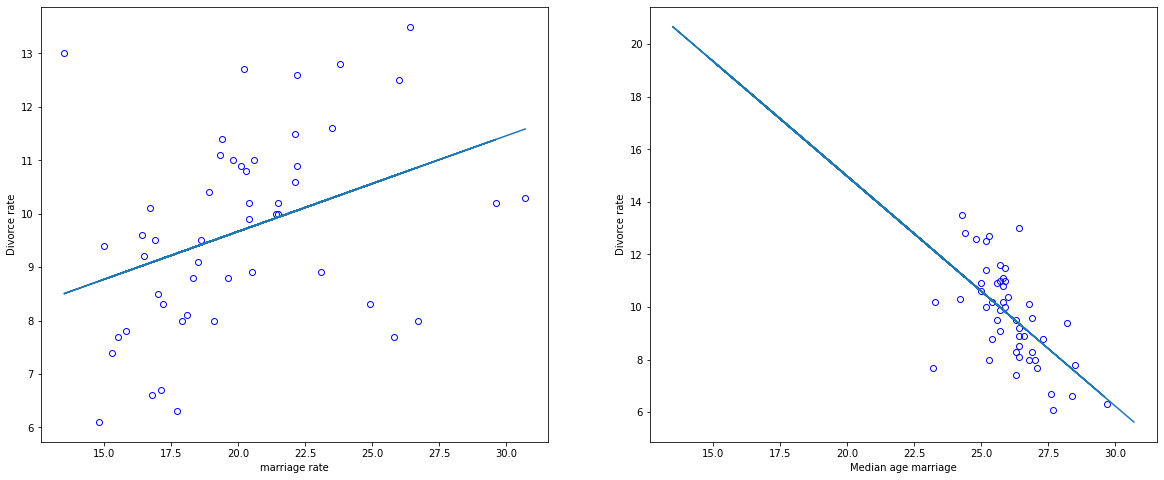

In [7]:
m1, b1 = np.polyfit( data["Marriage"], data["Divorce"], 1)
m2,b2=np.polyfit( data["MedianAgeMarriage"], data["Divorce"], 1)
fid, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].scatter(
    data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b"
)
ax[0].plot( data["Marriage"], m1* data["Marriage"] + b1)
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("marriage rate")
#ax[0].plot( data["Marriage"], data["Marriage"].mean() + data["Divorce"].mean() *data["Marriage"])
ax[1].scatter(
    data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b"
)
ax[1].plot( data["Marriage"], m2* data["Marriage"] + b2)
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")


<p>But does marriage cause divorce? In a trivial sense it obviously does: One cannot
get a divorce without first getting married. But there’s no reason high marriage rate must
be correlated with divorce. It’s easy to imagine high marriage rate indicating high cultural
valuation of marriage and therefore being associated with low divorce rate. So something is
suspicious here.</p><p>
Another predictor associated with divorce is the median age at marriage, displayed in
the right-hand plot iabove. Age at marriage is also a good predictor of divorce rate—
higher age at marriage predicts less divorce. Let’s load these data and standardize the variables
of interest:</p>

In [9]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

 Now lets try a regression on the median marriage age. First our model:

Di ∼ Normal(μ <sub>i </sub>, σ)

μ<sub>i</sub> = α + β<sub>A</sub>A<sub>i</sub>

α ∼ Normal(0, 0.2)


β<sub>A</sub> ∼ Normal(0, 0.5)


σ ∼ Exponential(1)

<p>
    where  D<sub>i</sub> is the standardized (zero centered, standard deviation one) divorce rate for State i, and
    A<sub>i</sub> is State i’s standardized median age at marriage.</p>
    
    
What about those priors? Since the outcome (Divorce rate) and the predictor  (median age) are both standardized, the
intercept α should end up very close to zero. 

What does the prior slope β<sub>A</sub> imply? If β<sub>A</sub> = 1,
that would imply that a change of one standard deviation in age at marriage is associated
likewise with a change of one standard deviation in divorce. To know whether or not that is
a strong relationship, you need to know how big a standard deviation of age at marriage is:

 
 

In [10]:
data["MedianAgeMarriage"].std()

1.2436303013880823

So when βA = 1, a change of 1.2 years in median age at marriage is associated with a full
standard deviation change in the outcome variable. That seems like an insanely strong relationship.
The prior above thinks that only 5% of plausible slopes more extreme than 1. We’ll
simulate from these priors in a moment, so you can see how they look in the outcome space.

In [11]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    
    m_5_1_trace = pm.sample()
    posteriorpredictivesamples=pm.sample_posterior_predictive( m_5_1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


In [28]:
prior_samples.keys()

dict_keys(['bA', 'sigma', 'a', 'divorce_rate_std', 'mu', 'sigma_log__'])

In [12]:
%matplotlib inline

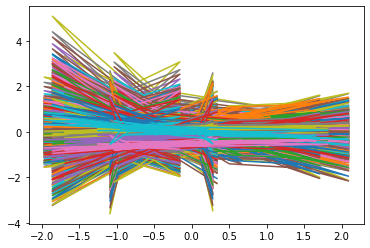

In [13]:

plt.plot(data["Divorce_std"],prior_samples["mu"].T)

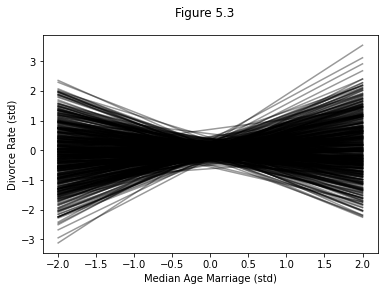

In [14]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, ba in zip(prior_samples["a"][:], prior_samples["bA"][:]):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");



Plausible regression lines implied
by the priors in m5.1. These are weakly informative
priors in that they allow some implusibly
strong relationships but generally bound
the lines to possible ranges of the variables.

Posterior distributions

 prior_samples = pm.sample_prior_predictive()
    
    m_5_1_trace = pm.sample()
    posteriorpredictivesamples=pm.sample_posterior_predictive( m_5_1_trace)

In [43]:
posteriorpredictivesamples

{'divorce_rate_std': array([[ 0.39178658, -0.17859216, -0.20108741, ...,  0.25702225,
         -0.26198648,  0.6007864 ],
        [ 1.30563879,  0.75495957, -0.70816861, ...,  1.10198513,
          0.90904415, -1.31234557],
        [-0.74213525, -0.47870377, -0.40282582, ...,  1.58375199,
         -2.39116511,  0.09709207],
        ...,
        [-0.65846873, -0.0863681 ,  0.45131275, ..., -0.11598348,
          0.74993568,  1.02343332],
        [ 0.8660111 ,  0.47918164,  0.70178935, ...,  0.06936279,
         -0.86019709,  0.83455152],
        [-0.45717341,  0.78067973,  1.56993014, ..., -0.21124352,
         -1.53788198, -1.21148976]])}

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


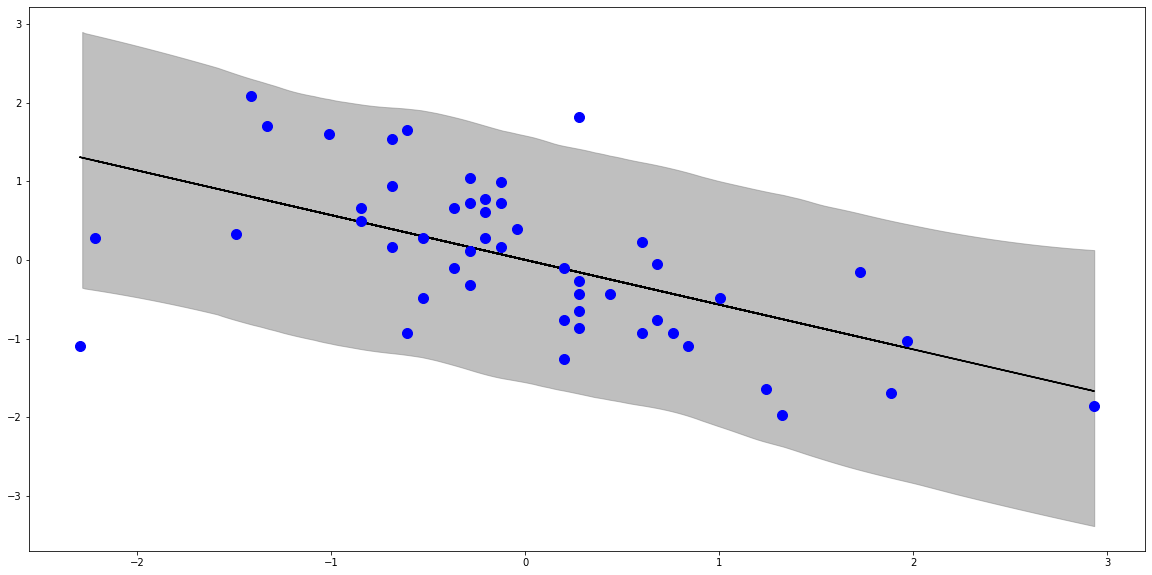

In [15]:
fig, ax = plt.subplots(figsize=(20,10))
az.plot_hdi(data["MedianAgeMarriage_std"], posteriorpredictivesamples["divorce_rate_std"], credible_interval=0.94, color='gray', ax=ax)
plt.plot(data["MedianAgeMarriage_std"],  m_5_1_trace["a"].mean() +  m_5_1_trace["bA"].mean() * (data["MedianAgeMarriage_std"]),color="black")
plt.plot(data["MedianAgeMarriage_std"],data["Divorce_std"], 'b.', markersize=20)
#plt.plot(df2.weight, tracedeterminist["alpha"].mean() + tracedeterminist["beta"].mean() * (df2.weight_c),color="black")
#plt.plot(df2.weight, df2.height, 'b.', markersize=20)

In [16]:
 m_5_1_trace["bA"].mean()

-0.570240218484769

 We can  see that posterior for βA is reliably negative, as seen

<h2> We can do the same analysis for divorce rate and marriage rate  </h2>

In [17]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"])

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/utils.py:660: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  warnings.warn(
/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


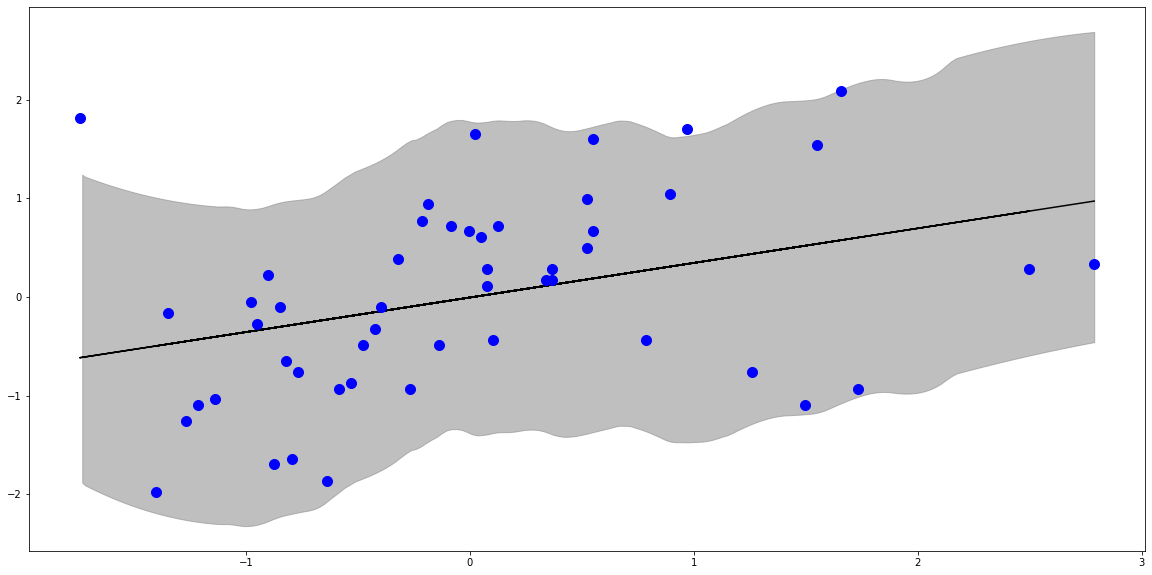

In [18]:
fig, ax = plt.subplots(figsize=(20,10))
az.plot_hdi(data["Marriage_std"], posteriorpredictivesamples["divorce_rate_std"], credible_interval=0.94, color='gray', ax=ax)
plt.plot(data["Marriage_std"],  m_5_2_trace["a"].mean() +  m_5_2_trace["bM"].mean() * (data["Marriage_std"]),color="black")
plt.plot(data["Marriage_std"],data["Divorce_std"], 'b.', markersize=20)

As you can see in the figure, this relationship isn’t as strong as the previous one.
But merely comparing parameter means between different bivariate regressions is no
way to decide which predictor is better. Both of these predictors could provide independent
value, or they could be redundant, or one could eliminate the value of the other.


To make sense of this, we’re going to have to think causally. And then, only after we’ve
done some thinking, a bigger regression model that includes both age at marriage and marriage
rate will help us.


In [19]:
m_5_2_trace["bM"].mean()

0.35067681270612167